In [9]:
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import seaborn as sns

from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

import skill_evaluation_functions as sf

In [4]:
pr_spatial = xr.open_dataset('../data.nosync/CHIRPS_pr_95pc_EW.nc')['precipitation_amount']
pr_spatial = pr_spatial.where(pr_spatial['time.year'] < 2023, drop=True)

time_values = pd.DataFrame(pr_spatial['time'].values)
time_values = time_values.rename(columns={0: 'date'})

In [6]:
pr_labels = pd.read_csv('../data.nosync/CHIRPS_pr_cluster_labels_5.csv')
pr_labels.columns = ['index', 'labels']
pr_labels.drop(pr_labels.tail(1).index,inplace=True)

pr_labels['values']=[1]*len(pr_labels)
label_indices_pd = pd.pivot_table(pr_labels, values='values', index=['index'],
                    columns=['labels'], aggfunc=np.sum).fillna(0)
label_indices = label_indices_pd.values

In [7]:
filepath_results = "results/"

## Brier Score & ROC-AUC

### CMM-VAE

In [10]:
# era5 cluster results
cmmvae_labels = pd.read_csv('../regime_calculation/results/cmmvae/cluster_probabilities_5.csv')[['label']]
cmmvae_labels_df = pd.concat([time_values, cmmvae_labels], axis=1) 
cmmvae_labels_df['date'] = pd.to_datetime(cmmvae_labels_df['date'])

# predicted clusters in s2s forecasts
cluster_prob_cmmvae = pd.read_csv('results/s2s_projections_cmmvae.csv')
cluster_prob_cmmvae = cluster_prob_cmmvae.drop(columns='Unnamed: 0')

cluster_prob_cmmvae['valid_date'] = pd.to_datetime(cluster_prob_cmmvae['valid_date'])
cluster_prob_cmmvae['date']=cluster_prob_cmmvae['valid_date']

merged_forecast_cmmvae = pd.merge(cluster_prob_cmmvae, cmmvae_labels_df, on=['date'], how='left')
merged_forecast_cmmvae = merged_forecast_cmmvae.dropna()

**BSS**

In [ ]:
bss_cmmvae = []

for leadtime in range(47):
    
    filtered_data = merged_forecast_cmmvae[merged_forecast_cmmvae['leadtime']==leadtime]
    
    y_true = filtered_data['label'].values
    y_forecast = filtered_data[['0', '1', '2', '3', '4']].values
    
    bs = sf.calculate_brier_skill_score_clusters_probabilistic(y_true, y_forecast)
    bsc = sf.brier_score_cluster_climatology(y_true, 5)
    bss = 1-bs/bsc
    
    bss_cmmvae.append(pd.DataFrame(data = {'Method': ['CMM-VAE'], 'Leadtime': [leadtime], 'BSS': [bss]}))
    
bss_cmmvae_df = pd.concat(bss_cmmvae)

**with bootstrap**

In [ ]:
# with bootstrap

bss_cmmvae_boot = []

for leadtime in range(47):
    
    print(leadtime)
    
    filtered_data = merged_forecast_cmmvae[merged_forecast_cmmvae['leadtime']==leadtime]
    
    for count in range(100):
        
        filtered_data_sampled = filtered_data.sample(frac=0.9, replace=True)
    
        y_true = filtered_data_sampled['label'].values
        y_forecast = filtered_data_sampled[['0', '1', '2', '3', '4']].values

        bs = sf.calculate_brier_skill_score_clusters_probabilistic(y_true, y_forecast)
        bsc = sf.brier_score_cluster_climatology(y_true, 5)
        bss = 1-bs/bsc

        bss_cmmvae_boot.append(pd.DataFrame(data = {'Method': ['CMM-VAE'], 'Leadtime': [leadtime], 'BSS': [bss]}))
    
bss_cmmvae_boot_df = pd.concat(bss_cmmvae_boot)
bss_cmmvae_boot_df.to_csv(filepath_results+'bss_s2s_cmm_bootstrapped_5.csv')

**ROC**

In [ ]:
label_name = 'label'
cmm_roc_auc_ls = []

for leadtime in range(47):
    
    filtered_data = merged_forecast_cmmvae[merged_forecast_cmmvae['leadtime']==leadtime]
    
    for count in range(100):
        
        filtered_data_sampled = filtered_data.sample(frac=0.9, replace=True)
    
        truth = filtered_data_sampled[label_name].values
        prediction = filtered_data_sampled[['0', '1', '2', '3', '4']].values

        score = roc_auc_score(truth, prediction, multi_class='ovo')

        cmm_roc_auc_ls.append(pd.DataFrame(data={'Method': ['CMM-VAE'], 'Leadtime': [leadtime], 'ROC_AUC': [score]}))
    
cmm_roc_auc = pd.concat(cmm_roc_auc_ls)
cmm_roc_auc.to_csv(filepath_results+'roc_cmm_5.csv')

### PCA

In [11]:
pca_labels = pd.read_csv('../regime_calculation/results/pca/cluster_labels_5.csv')[['label']]
pca_labels_df = pd.concat([time_values, pca_labels], axis=1) 
pca_labels_df['date'] = pd.to_datetime(pca_labels_df['date'])

cluster_prob_pca = pd.read_csv('results/s2s_projections_pca.csv')
cluster_prob_pca = cluster_prob_pca.drop(columns='Unnamed: 0')

cluster_prob_pca['valid_date'] = pd.to_datetime(cluster_prob_pca['valid_date'])
cluster_prob_pca['date']=cluster_prob_pca['valid_date']

merged_forecast_pca = pd.merge(cluster_prob_pca,pca_labels_df, on=['date'], how='left')
merged_forecast_pca = merged_forecast_pca.dropna()

**BSS**

In [ ]:
bss_pca = []

for leadtime in range(47):
    
    print(leadtime)
    
    filtered_data = merged_forecast_pca[merged_forecast_pca['leadtime']==leadtime]
    
    y_true = filtered_data['label'].values
    y_forecast = filtered_data[['0', '1', '2', '3', '4']].values
    
    bs = sf.calculate_brier_skill_score_clusters_probabilistic(y_true, y_forecast)
    bsc = sf.brier_score_cluster_climatology(y_true, 5)
    bss = 1-(bs/bsc)
    print(bss)
    
    bss_pca.append(pd.DataFrame(data = {'Method': ['PCA'], 'Leadtime': [leadtime], 'BSS': [bss]}))
    
bss_pca_df = pd.concat(bss_pca)

**with boostrap**

In [ ]:
bss_pca_boot = []

for leadtime in range(47):
    
    print(leadtime)
    
    filtered_data = merged_forecast_pca[merged_forecast_pca['leadtime']==leadtime]
    
    for count in range(100):
        
        filtered_data_sampled = filtered_data.sample(frac=0.9, replace=True)
    
        #y_true = filtered_data_sampled['pca_labels'].values
        y_true = filtered_data_sampled['label'].values
        y_forecast = filtered_data_sampled[['0', '1', '2', '3', '4']].values

        bs = sf.calculate_brier_skill_score_clusters_probabilistic(y_true, y_forecast)
        bsc = sf.brier_score_cluster_climatology(y_true, 5)
        bss = 1-(bs/bsc)

        bss_pca_boot.append(pd.DataFrame(data = {'Method': ['PCA'], 'Leadtime': [leadtime], 'BSS': [bss]}))
    
bss_pca_boot_df = pd.concat(bss_pca_boot)

bss_pca_boot_df.to_csv(filepath_results+'bss_s2s_pca_bootstrapped_5.csv')

**ROC**

In [42]:
label_name = 'label'
pca_roc_auc_ls = []

for leadtime in range(47):
    
    filtered_data = merged_forecast_pca[merged_forecast_pca['leadtime']==leadtime]
    
    for count in range(100):
        
        filtered_data_sampled = filtered_data.sample(frac=0.9, replace=True)
    
        truth = filtered_data_sampled[label_name].values
        prediction = filtered_data_sampled[['0', '1', '2', '3', '4']].values

        score = roc_auc_score(truth, prediction, multi_class='ovo')

        pca_roc_auc_ls.append(pd.DataFrame(data={'Method': ['PCA'], 'Leadtime': [leadtime], 'ROC_AUC': [score]}))
    

pca_roc_auc = pd.concat(pca_roc_auc_ls)

pca_roc_auc.to_csv(filepath_results+'roc_pca_5.csv')

### rCCA

In [12]:
cca_labels = pd.read_csv('../regime_calculation/results/cca/cluster_labels_5.csv')[['label']]
cca_labels_df = pd.concat([time_values, cca_labels], axis=1) 
cca_labels_df['date'] = pd.to_datetime(cca_labels_df['date'])

cluster_prob_cca = pd.read_csv('results/s2s_projections_rcca.csv')
cluster_prob_cca = cluster_prob_cca.drop(columns='Unnamed: 0')

cluster_prob_cca['valid_date'] = pd.to_datetime(cluster_prob_cca['valid_date'])
cluster_prob_cca['date']=cluster_prob_cca['valid_date']

merged_forecast_cca = pd.merge(cluster_prob_cca,cca_labels_df, on=['date'], how='left')
merged_forecast_cca = merged_forecast_cca.dropna()

**BSS**

In [ ]:
bss_cca = []

for leadtime in range(47):
    
    print(leadtime)
    
    filtered_data = merged_forecast_cca[merged_forecast_cca['leadtime']==leadtime]
    
    y_true = filtered_data['label'].values
    y_forecast = filtered_data[['0', '1', '2', '3', '4']].values
    
    bs = sf.calculate_brier_skill_score_clusters_probabilistic(y_true, y_forecast)
    bsc = sf.brier_score_cluster_climatology(y_true, 5)
    bss = 1-(bs/bsc)
    print(bss)
    
    bss_cca.append(pd.DataFrame(data = {'Method': ['CCA'], 'Leadtime': [leadtime], 'BSS': [bss]}))
    
bss_cca_df = pd.concat(bss_cca)

**with bootstrap**

In [ ]:
# brier score with bootstrap

bss_cca_boot = []

for leadtime in range(47):
    
    print(leadtime)
    
    filtered_data = merged_forecast_cca[merged_forecast_cca['leadtime']==leadtime]
    
    for count in range(100):
        
        filtered_data_sampled = filtered_data.sample(frac=0.9, replace=True)
    
        y_true = filtered_data_sampled['label'].values
        y_forecast = filtered_data_sampled[['0', '1', '2', '3', '4']].values

        bs = sf.calculate_brier_skill_score_clusters_probabilistic(y_true, y_forecast)
        bsc = sf.brier_score_cluster_climatology(y_true, 5)
        bss = 1-(bs/bsc)

        bss_cca_boot.append(pd.DataFrame(data = {'Method': ['CCA'], 'Leadtime': [leadtime], 'BSS': [bss]}))
    
bss_cca_boot_df = pd.concat(bss_cca_boot)

**ROC**

In [26]:
label_name = 'label'
cca_roc_auc_ls = []

for leadtime in range(47):
    
    filtered_data = merged_forecast_cca[merged_forecast_cca['leadtime']==leadtime]
    
    for count in range(100):
        
        filtered_data_sampled = filtered_data.sample(frac=0.9, replace=True)
    
        truth = filtered_data_sampled[label_name].values
        prediction = filtered_data_sampled[['0', '1', '2', '3', '4']].values

        score = roc_auc_score(truth, prediction, multi_class='ovo')

        cca_roc_auc_ls.append(pd.DataFrame(data={'Method': ['CCA'], 'Leadtime': [leadtime], 'ROC_AUC': [score]}))
    

cca_roc_auc = pd.concat(cca_roc_auc_ls)

In [28]:
bss_cca_boot_df.to_csv(filepath_results+'bss_s2s_rcca_bootstrapped_5.csv')
cca_roc_auc.to_csv(filepath_results+'roc_rcca_5.csv')

### BSS - plot and save with bootstrap

In [16]:
boot_cmm = pd.read_csv(filepath_results+'bss_s2s_cmm_bootstrapped_5.csv')
boot_pca = pd.read_csv(filepath_results+'bss_s2s_pca_bootstrapped_5.csv')
boot_cca = pd.read_csv(filepath_results+'bss_s2s_rcca_bootstrapped_5.csv')
boot_combined = pd.concat([boot_pca, boot_cca, boot_cmm])

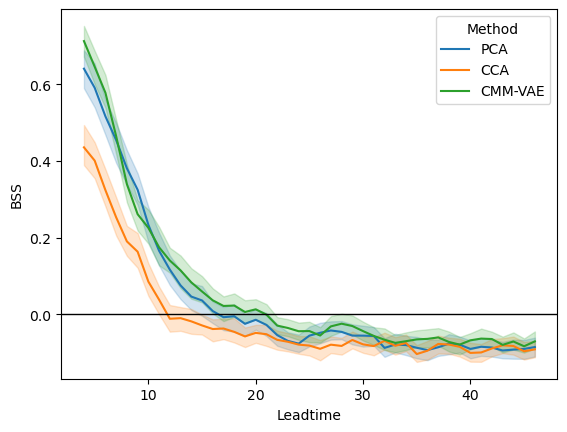

In [21]:
plot_data = boot_combined[boot_combined['Leadtime']>3]

ax=sns.lineplot(plot_data, x='Leadtime', y='BSS', hue='Method', errorbar=('pi', 95))
ax.axhline(y=0.0, linewidth=1, color='black', ls='-')
plt.savefig(filepath_results+'s2s_results_bss_bootstrap_95.png')

### Plot ROC-AUC

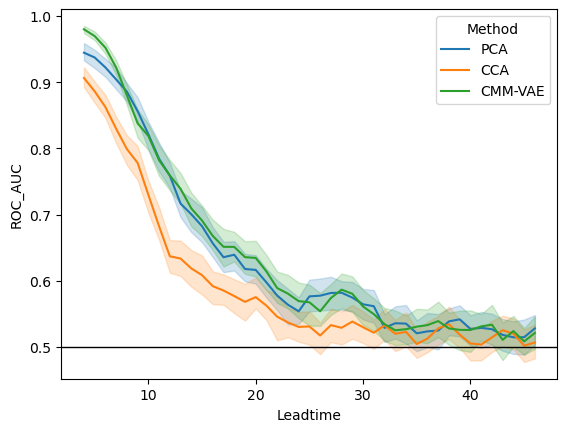

In [22]:
roc_cmm = pd.read_csv(filepath_results+'roc_cmm_5.csv')
roc_pca = pd.read_csv(filepath_results+'roc_pca_5.csv')
roc_cca = pd.read_csv(filepath_results+'roc_rcca_5.csv')

roc_overall = pd.concat([roc_pca, roc_cca, roc_cmm])

plot_data = roc_overall[roc_overall['Leadtime']>3]

ax=sns.lineplot(plot_data, x='Leadtime', y='ROC_AUC', hue='Method', errorbar=('pi', 95))
ax.axhline(y=0.5, linewidth=1, color='black', ls='-')
plt.savefig(filepath_results+'s2s_results_ROC_AUC_boot.png')

## Resolution

In [13]:
bin_number = 11

In [14]:
cmmvae_resolution = []

cmm_order = [0, 1, 2, 3, 4]

climatology = []
for j in range(5):    
    climatology.append((merged_forecast_cmmvae['label']==j).sum()/len(merged_forecast_cmmvae['label']))
    
for leadtime in range(47):

    for i in range(5):

        data = merged_forecast_cmmvae[merged_forecast_cmmvae['leadtime']==leadtime]

        y_prob = data[str(i)].values
        y_prob[y_prob>1]=1

        data['new_label']=0
        data.loc[data['label']==i, 'new_label'] = 1
        y_true = data['new_label'].values

        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=bin_number, strategy='quantile')
        resolution = np.sum((prob_true - climatology[i])**2)/len(prob_true)
        
        cmmvae_resolution.append(pd.DataFrame(data={'Method': ['CMM-VAE'], 'Leadtime': [leadtime],
                                                    'Regime': [cmm_order[i]], 'Resolution': [resolution]}))
        
        
cmmvae_resolution_df = pd.concat(cmmvae_resolution)

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1281459985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1281459985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1281459985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1281459985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1281459985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1281459985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1281459985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1281459985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1281459985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [18]:
pca_resolution = []

pca_order = [0, 1, 2, 3, 4]

climatology = []
for j in range(5):    
    climatology.append((merged_forecast_pca['label']==j).sum()/len(merged_forecast_pca['label']))

for leadtime in range(47):
    for i in range(5):

        data = merged_forecast_pca[merged_forecast_pca['leadtime']==leadtime]

        y_prob = data[str(i)].values
        y_prob[y_prob>1]=1

        data['new_label']=0
        data.loc[data['label']==i, 'new_label'] = 1
        y_true = data['new_label'].values

        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=bin_number, strategy='quantile')
        resolution = np.sum((prob_true - climatology[i])**2)/len(prob_true)
        
        pca_resolution.append(pd.DataFrame(data={'Method': ['PCA'], 'Leadtime': [leadtime],
                                                    'Regime': [pca_order[i]], 'Resolution': [resolution]}))
        
        
pca_resolution_df = pd.concat(pca_resolution)

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1009526412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1009526412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1009526412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1009526412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1009526412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1009526412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1009526412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1009526412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1009526412.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [20]:
cca_resolution = []

cca_order = [0, 1, 2, 3, 4]

climatology = []
for j in range(5):    
    climatology.append((merged_forecast_cca['label']==j).sum()/len(merged_forecast_cca['label']))

for leadtime in range(47):

    for i in range(5):


        data = merged_forecast_cca[merged_forecast_cca['leadtime']==leadtime]

        y_prob = data[str(i)].values
        y_prob[y_prob>1]=1

        data['new_label']=0
        data.loc[data['label']==i, 'new_label'] = 1
        y_true = data['new_label'].values

        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=bin_number, strategy='quantile')

        resolution = np.sum((prob_true - climatology[i])**2)/len(prob_true)

        
        cca_resolution.append(pd.DataFrame(data={'Method': ['CCA'], 'Leadtime': [leadtime],
                                                    'Regime': [cca_order[i]], 'Resolution': [resolution]}))
        
        
cca_resolution_df = pd.concat(cca_resolution)

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/2009091872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/2009091872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/2009091872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/2009091872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/2009091872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/2009091872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/2009091872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/2009091872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label']=0
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/2009091872.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

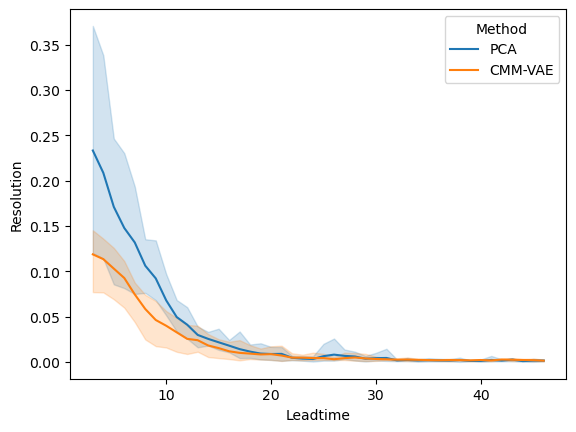

In [26]:
resolution_all = pd.concat([pca_resolution_df, cmmvae_resolution_df])
plot_data = resolution_all[resolution_all['Leadtime']>2]
sns.lineplot(data=plot_data, x='Leadtime', y='Resolution', hue='Method', errorbar=('pi', 100))
plt.savefig('results/resolution.png')

## Reliability

In [22]:
reliability_cmm_ls = []

cmm_order = [0, 1, 2, 3, 4]

for leadtime in range(47):
    
    filtered_data = merged_forecast_cmmvae[merged_forecast_cmmvae['leadtime']==leadtime]

    for i in range(5):

        data = filtered_data.copy()

        y_prob = data[str(i)].values
        y_prob[y_prob>1]=1

        data['new_label']=0
        data['new_label'][data['label']==i]=1
        y_true = data['new_label'].values

        prob_true, prob_pred = calibration_curve(y_true, y_prob, pos_label = 1,n_bins=bin_number, strategy='quantile')

        reliability_cmm = 5*np.sum((prob_true-prob_pred)**2)/len(prob_pred)

        reliability_cmm_ls.append(pd.DataFrame(data={'Method': ['CMM-VAE'], 'Leadtime': [leadtime],
                                                     'Regime': [cmm_order[i]],
                                                     'Reliability': [reliability_cmm]}))
        
reliability_cmm_df = pd.concat(reliability_cmm_ls)  

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/4075540875.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [23]:
reliability_pca_ls = []

pca_order = [0, 1, 2, 3, 4]

for leadtime in range(47):
    
    filtered_data = merged_forecast_pca[merged_forecast_pca['leadtime']==leadtime]

    for i in range(5):

        data = filtered_data.copy()

        y_prob = data[str(i)].values
        y_prob[y_prob>1]=1

        data['new_label']=0
        data['new_label'][data['label']==i]=1
        y_true = data['new_label'].values

        prob_true, prob_pred = calibration_curve(y_true, y_prob, pos_label = 1, n_bins=bin_number, strategy='quantile')

        reliability = 5*np.sum((prob_true-prob_pred)**2)/len(prob_pred)

        reliability_pca_ls.append(pd.DataFrame(data={'Method': ['PCA'], 'Leadtime': [leadtime],
                                                     'Regime': [pca_order[i]],
                                                     'Reliability': [reliability]}))
        
reliability_pca_df = pd.concat(reliability_pca_ls) 

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/1536241272.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [24]:
reliability_cca_ls = []

cca_order = [0, 1, 2, 3, 4]

for leadtime in range(47):
    
    filtered_data = merged_forecast_cca[merged_forecast_cca['leadtime']==leadtime]

    for i in range(5):

        data = filtered_data.copy()

        y_prob = data[str(i)].values
        y_prob[y_prob>1]=1

        data['new_label']=0
        data['new_label'][data['label']==i]=1
        y_true = data['new_label'].values

        prob_true, prob_pred = calibration_curve(y_true, y_prob, pos_label = 1, n_bins=bin_number, strategy='quantile')

        reliability = 5*np.sum((prob_true-prob_pred)**2)/len(prob_pred)

        reliability_cca_ls.append(pd.DataFrame(data={'Method': ['CCA'], 'Leadtime': [leadtime],
                                                     'Regime': [cca_order[i]],
                                                     'Reliability': [reliability]}))
        
reliability_cca_df = pd.concat(reliability_cca_ls) 

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['new_label'][data['label']==i]=1
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_22339/348109734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

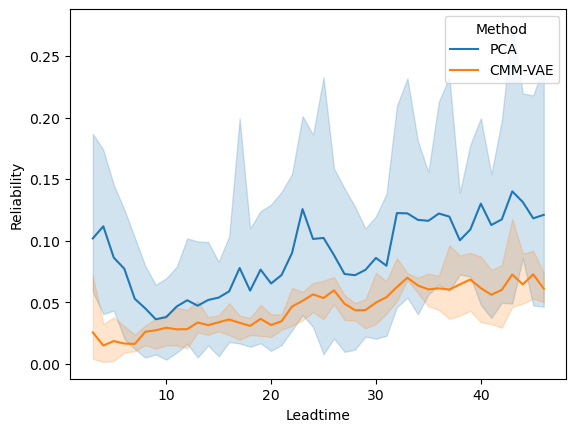

In [27]:
reliability_all = pd.concat([reliability_pca_df, reliability_cmm_df])
plot_data = reliability_all[reliability_all['Leadtime']>2]
sns.lineplot(data=plot_data, x='Leadtime', y='Reliability', hue='Method', errorbar=('pi', 100))
plt.savefig('results/reliability.png')